In [1953]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


# Text preprocessing

In [1954]:
mickiewicz_pan_tadeusz = open('mickiewicz/pan_tadeusz.txt', 'r').read()
mickiewicz_dziady = open('mickiewicz/dziady.txt', 'r').read()

mickiewicz = mickiewicz_pan_tadeusz + mickiewicz_dziady

len(mickiewicz)

466662

In [1955]:
slowacki_kordian = open('slowacki/kordian.txt', 'r').read()
len(slowacki_kordian)
słowacki = slowacki_kordian

In [1956]:
tuwim_matka = open('tuwim/matka.txt', 'r').read()
tuwim_lokomotywa = open('tuwim/lokomotywa.txt', 'r').read()
tuwim = tuwim_matka + tuwim_lokomotywa
len(tuwim)

2940

In [1957]:
bronte = open('bronte/jane_eyre_fragment.txt', 'r').read()
len(bronte)

112892

In [1958]:
# !pip install nltk

In [1959]:
# !pip install inflect


In [1960]:
from helpers import remove_non_ascii, to_lowercase, remove_punctuation, replace_numbers, remove_stopwords, stem_words, lemmatize_verbs, normalize

In [1961]:
import nltk
sent = nltk.data.load(
    'tokenizers/punkt/polish.pickle'
)

def remove_end_lines(text):
    data = []
    for item in text:
        data.append(item.replace('\n', ' '))
    return data

def preprocess(text):
    words = sent.tokenize(text)
    words = normalize(words)
    words = remove_end_lines(words)
    print(words[:10])
    return words

In [1962]:
mickiewicz_data = preprocess(mickiewicz)
tuwim_data = preprocess(tuwim)
slowacki_data = preprocess(słowacki)
bronte_data = preprocess(bronte)
print(len(mickiewicz_data))
print(len(tuwim_data))
print(len(slowacki_data))
print(len(bronte_data))


['adam mickiewicz  pan tadeusz czyli ostatni zajazd na litwie   ksiega pierwsza    gospodarstwo  powrot panicza  spotkanie sie pierwsze w pokoiku drugie u stou  wazna sedziego nauka o grzecznosci  podkomorzego uwagi polityczne nad modami  poczatek sporu o kusego i sokoa  zale wojskiego  ostatni wozny trybunau  rzut oka na owczesny stan polityczny litwy i europy      litwo', 'ojczyzno moja', 'ty jestes jak zdrowie ile cie trzeba cenic ten tylko sie dowie kto cie straci', 'dzis pieknosc twa w caej ozdobie widze i opisuje bo tesknie po tobie', 'panno swieta co jasnej bronisz czestochowy i w ostrej swiecisz bramie', 'ty co grod zamkowy nowogrodzki ochraniasz z jego wiernym ludem', 'jak mnie dziecko do zdrowia powrocias cudem gdy od paczacej matki pod twoja opieke ofiarowany martwa podniosem powieke i zaraz mogem pieszo do twych swiatyn progu isc za wrocone zycie podziekowac bogu tak nas powrocisz cudem na ojczyzny ono', 'tymczasem przenos moja dusze uteskniona do tych pagorkow lesnych do t

In [1963]:
import pandas as pd

mickiewicz_dict = {
    "text" : mickiewicz_data,
    "label": np.zeros(len(mickiewicz_data), dtype=np.int16)
}

# tuwim_dict = {
#     "text" : tuwim_data,
#     "label": np.ones(len(tuwim_data), dtype=np.int16)
# }

slowacki_dict = {
    "text" : slowacki_data,
    "label": np.full(len(slowacki_data), 1, dtype=np.int16)
}

bronte_dict = {
    "text" : bronte_data,
    "label": np.full(len(bronte_data), 2, dtype=np.int16)
}

print(mickiewicz_dict["label"])
mickiewicz_df = pd.DataFrame.from_dict(mickiewicz_dict)
# tuwim_df = pd.DataFrame.from_dict(tuwim_dict)
slowacki_df = pd.DataFrame.from_dict(slowacki_dict)
bronte_df = pd.DataFrame.from_dict(bronte_dict)
print(mickiewicz_df.head())
# print(tuwim_df.head())


[0 0 0 ... 0 0 0]
                                                text  label
0  adam mickiewicz  pan tadeusz czyli ostatni zaj...      0
1                                      ojczyzno moja      0
2  ty jestes jak zdrowie ile cie trzeba cenic ten...      0
3  dzis pieknosc twa w caej ozdobie widze i opisu...      0
4  panno swieta co jasnej bronisz czestochowy i w...      0


In [1964]:
df = pd.concat([mickiewicz_df, slowacki_df, bronte_df], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,text,label
0,serwis potem zabrany czasu wojny szwedzkiej pr...,0
1,siedemdziesiat dwa lat liczy maciej starzec dz...,0
2,a na boskie rany,0
3,wojna tuz nad nami,0
4,w innych krajach jak sysze trzyma urzad drabow...,0


In [1965]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000, min_df= 3, max_df=0.6)
X = vectorizer.fit_transform(df["text"]).toarray()
X[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [1966]:
y = df["label"].values
y
len(y)

6611

In [1967]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape


(5288, 1000)

In [1968]:
import torch
import torch.nn as nn

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()


In [1969]:
X_train.shape, X_train.shape

(torch.Size([5288, 1000]), torch.Size([5288, 1000]))

In [1970]:
input_size = 1000
output_size = 4
hidden_size = 500

In [1971]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, X):
        out = self.fc1(X)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.softmax(out)
        return out

In [1972]:
from sklearn.metrics import roc_auc_score
def train_model(model, X_train, y_train, epochs, lr):
    model.train()
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_data = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(X_train)
        loss = criterion(out, y_train)
        loss_data.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch} loss is {loss}")

    plt.figure(figsize=(8, 4))
    plt.plot(loss_data, label="Training loss")
    plt.legend()
    return model

def test_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        roc_auc = roc_auc_score(y_test, output, multi_class="ovo")

        _, predicted = torch.max(output, 1)

        correct = (predicted == y_test).sum().item()

        print(X_test[:10])
        print(y_test[:10])
        print(predicted[:10])

        print(f"Accuracy: {correct/len(y_test)}")
        print(f"ROC AUC: {roc_auc}")


Epoch 0 loss is 1.3952254056930542
Epoch 10 loss is 1.3739475011825562
Epoch 20 loss is 1.3507453203201294
Epoch 30 loss is 1.3221303224563599
Epoch 40 loss is 1.2850475311279297
Epoch 50 loss is 1.2369393110275269
Epoch 60 loss is 1.1766055822372437
Epoch 70 loss is 1.1094326972961426
Epoch 80 loss is 1.0476446151733398
Epoch 90 loss is 0.9991100430488586
Epoch 100 loss is 0.9596875905990601
Epoch 110 loss is 0.9247461557388306
Epoch 120 loss is 0.8925307393074036
Epoch 130 loss is 0.8610468506813049
Epoch 140 loss is 0.8286484479904175
Epoch 150 loss is 0.7942129969596863
Epoch 160 loss is 0.756898820400238
Epoch 170 loss is 0.7165942192077637
Epoch 180 loss is 0.6737816333770752
Epoch 190 loss is 0.629703164100647
Epoch 200 loss is 0.5857967138290405
Epoch 210 loss is 0.5436259508132935
Epoch 220 loss is 0.504561722278595
Epoch 230 loss is 0.4695298969745636
Epoch 240 loss is 0.4388643205165863
Epoch 250 loss is 0.41236916184425354
Epoch 260 loss is 0.3896239697933197
Epoch 270 loss

ValueError: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes

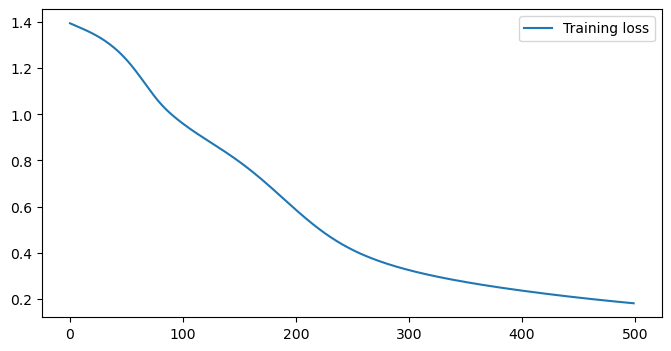

In [1973]:
epochs = 500
learning_rate = 0.0001

model = Net()

model = train_model(model, X_train, y_train, epochs, learning_rate)
test_model(model, X_test, y_test)


In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
X, y = load_iris(return_X_y=True)
print(y.shape)
clf = LogisticRegression(solver="liblinear").fit(X, y)
print(clf.predict_proba(X).shape)
roc_auc_score(y, clf.predict_proba(X), multi_class='ovr')

(150,)
(150, 3)


0.9913333333333334

In [ ]:
class ConvolutionalNet(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim):
        super(ConvolutionalNet, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, hidden_size, 3, padding=1)
        self.batchNorm1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(0.3)
        # self.pool1 = nn.MaxPool1d(3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, 3, padding=1)
        # self.pool2 = nn.MaxPool1d(3, stride=1, padding=1)
        self.batchNorm2 = nn.BatchNorm1d(hidden_size)
        self.fc1 = nn.Linear(hidden_size, 500)
        self.fc2 = nn.Linear(500, output_dim)
        self.softMax = nn.Softmax()

    def forward(self, X):
        X = X.squeeze(0)
        out = self.conv1(X)
        # out = self.pool1(out)
        out = out.T
        out = self.batchNorm1(out)
        out = out.T
        out = self.dropout(out)
        out = self.conv2(out)
        # out = self.pool2(out)
        out = out.T
        out = self.batchNorm2(out)
        out = out.T
        out = self.dropout(out)
        out = self.fc1(out.T)
        out = self.fc2(out)
        out = self.softMax(out)
        return out


/Users/krystynawaniova/opt/miniconda3/envs/mldd23/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 0 loss is 1.1024304628372192


Epoch 10 loss is 0.8958378434181213
Epoch 20 loss is 0.7362686991691589
Epoch 30 loss is 0.6539173722267151
Epoch 40 loss is 0.618255078792572
Epoch 50 loss is 0.6029603481292725
Epoch 60 loss is 0.5944657325744629
Epoch 70 loss is 0.5909842848777771
Epoch 80 loss is 0.5888648629188538
Epoch 90 loss is 0.5873066782951355
Epoch 100 loss is 0.5861530900001526
Epoch 110 loss is 0.5840400457382202
Epoch 120 loss is 0.5838475823402405
Epoch 130 loss is 0.5832175016403198
Epoch 140 loss is 0.5826820731163025
Epoch 150 loss is 0.5824298858642578
Epoch 160 loss is 0.5819775462150574
Epoch 170 loss is 0.5821532011032104
Epoch 180 loss is 0.5819277167320251
Epoch 190 loss is 0.5818344950675964
Epoch 200 loss is 0.5815555453300476
Epoch 210 loss is 0.5815309882164001
Epoch 220 loss is 0.5815644264221191
Epoch 230 loss is 0.5812825560569763
Epoch 240 loss is 0.5812718868255615
Epoch 250 loss is 0.5811854004859924
Epoch 260 loss is 0.581086277961731
Epoch 270 loss is 0.5811387896537781
Epoch 280 lo

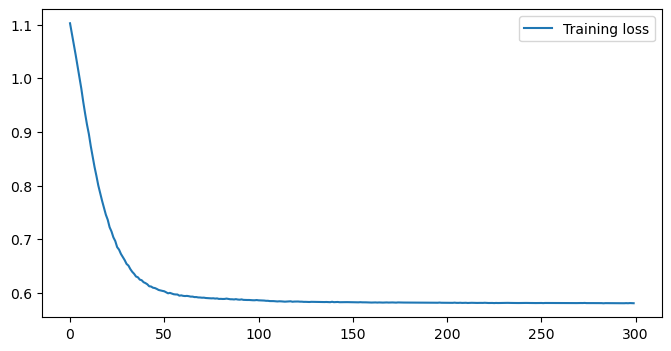

In [ ]:
epochs = 300
learning_rate = 0.0001

model = ConvolutionalNet(input_dim=input_size, hidden_size=512, output_dim=3)
lr= 0.0001

model = train_model(model, X_train.T, y_train, epochs, learning_rate)


In [ ]:
test_model(model, X_test.T, y_test)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0, 0, 1, 0, 0, 2, 0, 0, 0, 1])
tensor([0, 1, 1, 0, 0, 2, 0, 0, 2, 0])
Accuracy: 0.6704459561602418
ROC AUC: 0.8189582189318152


In [ ]:
test_model(model, X_test.T, y_test)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([0, 0, 1, 0, 0, 2, 0, 0, 0, 1])
tensor([0, 1, 1, 0, 0, 2, 0, 0, 2, 0])
Accuracy: 0.6704459561602418
ROC AUC: 0.8189582189318152


/Users/krystynawaniova/opt/miniconda3/envs/mldd23/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
# print(tuwim_data)
# tuwim_data_set = set(tuwim_data)

In [ ]:
# import pandas as pd
# import os
# class CustomImageDataset():
#     def __init__(self, words, labels):
#         self.labels = labels
#         self.words = words

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
#         # image = read_image(img_path)
#         label = self.img_labels.iloc[idx, 1]
#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             label = self.target_transform(label)
#         return image, label

In [ ]:
# def word_pairs(words):
#     pairs = []
#     for i in range(len(words) - 1):
#          pairs.append((words[i], words[i + 1]))
#     return pairs

# def convert_pairs_to_vectors(pairs, word2idx):
#     x,y=[],[]
#     for pair in pairs:
#         x.append(word2idx[pair[0]])
#         y.append(word2idx[pair[1]])
#     return x,y

# def create_word2idx(words):
#     word2idx = {word: i for i, word in enumerate(set(words))}
#     idx2word = {i: word for word, i in word2idx.items()}
#     return word2idx, idx2word

# word2idx, idx2word = create_word2idx(tuwim_data)
# word_pairs(tuwim_data)
# vectors = convert_pairs_to_vectors(word_pairs(tuwim_data), word2idx)

In [ ]:
# embeds = nn.Embedding(len(tuwim_data), 2)  # 2 words in vocab, 5 dimensional embeddings
# lookup_tensor = torch.tensor(vectors, dtype=torch.long)
# embeded_tuwim = embeds(lookup_tensor)[0].detach().numpy()
# # print(embeded_tuwim)

# import matplotlib.pyplot as plt
# for i, label in enumerate(set(tuwim_data)):
#     # print(embeded_tuwim[i])
#     x, y = embeded_tuwim[i]
#     plt.scatter(x, y)
#     plt.text(x, y, label)